Zip Polygon Extractor

In [1]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon, Polygon

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

# Initialize the GeoDataFrame and the list of dictionaries
gdf = gpd.GeoDataFrame()
mongo_data_list = []

def create_postal_code_gdf(place_name, tags):
    global gdf, mongo_data_list  # Use the global GeoDataFrame and list

    # Fetch place polygons
    place_polygons = ox.features_from_place(place_name, tags)

    # Filter for both Polygons and MultiPolygons
    polygon_mask = place_polygons['geometry'].apply(lambda geom: isinstance(geom, (Polygon, MultiPolygon)))

    # Create GeoDataFrame and drop rows with missing postal_code or geometry
    gdf = gpd.GeoDataFrame(place_polygons[polygon_mask].dropna(subset=['postal_code', 'geometry']))

    # Create a list of dictionaries with postal codes and GeoJSON geometries
    for idx, row in gdf.iterrows():
        postal_code = row['postal_code']
        geometry = row['geometry']

        # Convert Shapely geometry to GeoJSON format
        geojson_geometry = json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']

        # Create a dictionary with postal code and GeoJSON geometry
        postal_code_data = {
            "postal_code": postal_code,
            "geometry": geojson_geometry
        }

        # Add to the list
        mongo_data_list.append(postal_code_data)

# Example usage of the function
place_name = "Germany"
tags = {"boundary": "postal_code"}

# Call the function to populate the GeoDataFrame and the list
create_postal_code_gdf(place_name, tags)

# Now 'gdf' contains the GeoDataFrame with postal_code and geometry columns
# 'mongo_data_list' contains the list of dictionaries

# Save GeoJSON data to a file
with open('Germany_postal_codes.geojson', 'w') as file:
    json.dump({"type": "FeatureCollection", "features": mongo_data_list}, file, indent=2)



Plot & Check GeoPandasDataFrame Data

8274

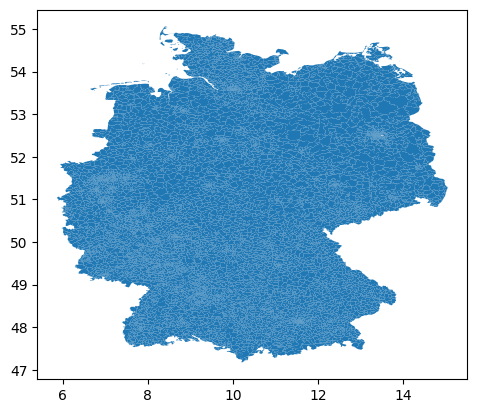

In [2]:
gdf.plot(), 
len(mongo_data_list)

MongoDB Connection & Data Integration

In [3]:
from pymongo import MongoClient
import json

class MongoDBConnector:
    def __init__(self, database_name, collection_name):
        self.client = MongoClient('localhost', 27017)
        self.db = self.client[database_name]
        self.collection = self.db[collection_name]

    def connect_to_local_mongodb(self):
        print("Connected to local MongoDB")
        return self.client, self.collection

    def insert_geojson_data(self, geojson_file_path, chunk_size=1000):
        with open(geojson_file_path, 'r') as file:
            geojson_data = json.load(file)

        # Assuming GeoJSON is a list of features directly
        features = geojson_data['features']
        for i in range(0, len(features), chunk_size):
            chunk = features[i:i + chunk_size]
            self.collection.insert_many(chunk)
            print(f"Inserted {len(chunk)} features into local MongoDB collection '{self.collection.name}'.")

    def close_connection(self):
        self.client.close()
        print("Closed MongoDB connection.")

# Example usage of the class
if __name__ == "__main__":
    # User input for the database and collection names
    database_name = "ZIP_Poly_Ger_DB_e"
    collection_name = "ZIP_Poly_Ger_Collection_e"

    # Create an instance of MongoDBConnector
    mongo_connector = MongoDBConnector(database_name, collection_name)

    # Connect to MongoDB
    mongo_client, mongo_collection = mongo_connector.connect_to_local_mongodb()

    # Example GeoJSON file path
    geojson_file_path = 'Germany_postal_codes.geojson'  # Update the file path accordingly

    # Insert GeoJSON data into MongoDB
    mongo_connector.insert_geojson_data(geojson_file_path, chunk_size=1000)

    # Close MongoDB connection when done
    mongo_connector.close_connection()


Connected to local MongoDB
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 274 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Closed MongoDB connection.


Postal Code to Polygon Converter

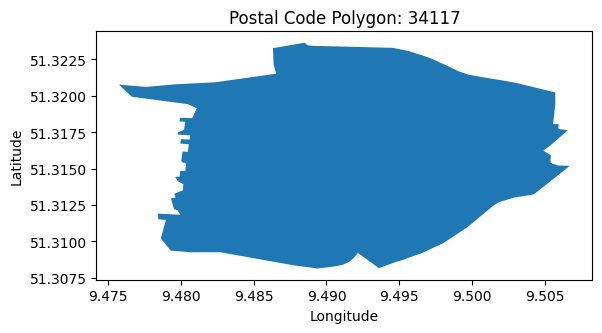

Selected Polygon Information:
POLYGON ((9.4757436 51.3207645, 9.4776032 51.3206073, 9.4796463 51.3207892, 9.4823482 51.320925, 9.4865459 51.3215156, 9.4863685 51.3221459, 9.4863246 51.3232692, 9.4885094 51.323645, 9.4886636 51.3235004, 9.4887893 51.3234516, 9.4891333 51.3234269, 9.491381 51.3233725, 9.4945481 51.3232914, 9.4956217 51.3230797, 9.4966232 51.3227593, 9.4971661 51.3225718, 9.4984949 51.321968, 9.499068 51.3216853, 9.4997424 51.3214482, 9.5009621 51.3212365, 9.5021754 51.3210394, 9.5030204 51.3208864, 9.5057135 51.3202296, 9.5057238 51.3194333, 9.5055623 51.3180545, 9.5059413 51.3180525, 9.5059333 51.3177153, 9.506594 51.3176393, 9.5054007 51.3166035, 9.5048986 51.3162318, 9.5054078 51.3159155, 9.5053889 51.3154057, 9.5056556 51.3152783, 9.505686 51.3153018, 9.5058858 51.3152088, 9.5067184 51.3151902, 9.5042477 51.3132263, 9.5028925 51.3130033, 9.5018798 51.312701, 9.5014944 51.3124757, 9.4996728 51.3109643, 9.4980295 51.3098796, 9.4964866 51.3091642, 9.4958408 51.3089457, 

In [4]:
import json
from shapely.geometry import shape, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    """
    Retrieves GeoJSON data from MongoDB collection.
    """
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_polygon(coordinates):
    """
    Converts coordinates to a Shapely Polygon.
    """
    return Polygon(coordinates)

def plot_polygon(postal_code_polygons, postal_code):
    """
    Plots the polygon for a given postal code and returns the polygon.
    """
    polygon = postal_code_polygons.get(postal_code)
    if polygon:
        gdf = gpd.GeoDataFrame(geometry=[polygon])
        gdf.plot()
        plt.title(f"Postal Code Polygon: {postal_code}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        return polygon
    else:
        print(f"No polygon found for postal code: {postal_code}")
        return None

# Example usage
if __name__ == "__main__":
    # MongoDB configuration
    database_name = "ZIP_Poly_Ger_DB_c"
    collection_name = "ZIP_Poly_Ger_Collection_c"

    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Retrieve GeoJSON data from MongoDB
    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    # Load GeoJSON data from MongoDB for comparison
    postal_code_polygons_mongo = {document.get('postal_code'): coordinates_to_polygon(document.get('geometry')['coordinates'][0]) for document in geojson_data_from_mongo['features']}

    # Input the postal code you want to plot
    input_postal_code = input("Enter a postal code: ")

    # Plot the polygon for the specified postal code and get the polygon
    selected_polygon = plot_polygon(postal_code_polygons_mongo, input_postal_code)

    # Output the polygon information
    if selected_polygon:
        print("Selected Polygon Information:")
        print(selected_polygon)

    # Close MongoDB connection when done
    mongo_client.close()


Coordinate to nearest Postal Code & Polygon

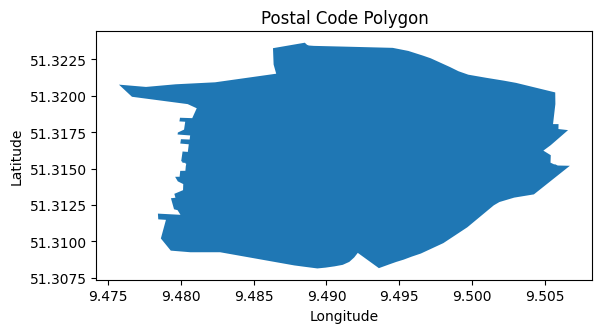

The postal code for the point (51.316669, 9.5) is: 34117
Selected Polygon Information:
POLYGON ((9.4757436 51.3207645, 9.4776032 51.3206073, 9.4796463 51.3207892, 9.4823482 51.320925, 9.4865459 51.3215156, 9.4863685 51.3221459, 9.4863246 51.3232692, 9.4885094 51.323645, 9.4886636 51.3235004, 9.4887893 51.3234516, 9.4891333 51.3234269, 9.491381 51.3233725, 9.4945481 51.3232914, 9.4956217 51.3230797, 9.4966232 51.3227593, 9.4971661 51.3225718, 9.4984949 51.321968, 9.499068 51.3216853, 9.4997424 51.3214482, 9.5009621 51.3212365, 9.5021754 51.3210394, 9.5030204 51.3208864, 9.5057135 51.3202296, 9.5057238 51.3194333, 9.5055623 51.3180545, 9.5059413 51.3180525, 9.5059333 51.3177153, 9.506594 51.3176393, 9.5054007 51.3166035, 9.5048986 51.3162318, 9.5054078 51.3159155, 9.5053889 51.3154057, 9.5056556 51.3152783, 9.505686 51.3153018, 9.5058858 51.3152088, 9.5067184 51.3151902, 9.5042477 51.3132263, 9.5028925 51.3130033, 9.5018798 51.312701, 9.5014944 51.3124757, 9.4996728 51.3109643, 9.4980295

In [5]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon, Polygon, Point
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    """
    Retrieves GeoJSON data from MongoDB collection.
    """
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_geometry(coordinates):
    """
    Converts coordinates to a Shapely Polygon or MultiPolygon.
    """
    # Check if coordinates are nested (indicating a polygon with holes)
    if isinstance(coordinates[0][0], list):
        # Create a MultiPolygon
        return MultiPolygon([Polygon(part) for part in coordinates])
    else:
        # Create a Polygon
        return Polygon(coordinates)

def insert_data_to_mongodb(data, collection):
    """
    Inserts GeoJSON data into MongoDB collection.
    """
    collection.insert_many(data['features'])
    print(f"Inserted {len(data['features'])} features into MongoDB collection '{collection.name}'.")

def plot_polygon(polygon):
    """
    Plots a Shapely Polygon.
    """
    gdf = gpd.GeoDataFrame(geometry=[polygon])
    gdf.plot()
    plt.title("Postal Code Polygon")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

def get_postal_code_for_point(point, postal_code_polygons):
    """
    Returns the postal code and polygon for a given Point and postal code polygons.
    """
    for postal_code, polygon in postal_code_polygons.items():
        if polygon.contains(point):
            return postal_code, polygon

    return None, None

# Example usage
if __name__ == "__main__":
    # MongoDB configuration
    database_name = "ZIP_Poly_Ger_DB_e"
    collection_name = "ZIP_Poly_Ger_Collection_e"

    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Retrieve GeoJSON data from MongoDB
    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    # Load GeoJSON data from MongoDB for comparison
    postal_code_polygons_mongo = {document.get('postal_code'): coordinates_to_geometry(document.get('geometry')['coordinates'][0]) for document in geojson_data_from_mongo['features']}

    # Input latitude and longitude for the point
    latitude = float(51.316669)
    longitude = float(9.500000)

    # Create a Point object for the specified latitude and longitude
    point = Point(longitude, latitude)

    # Get the postal code and polygon for the specified point
    postal_code, selected_polygon = get_postal_code_for_point(point, postal_code_polygons_mongo)

    # Plot the polygon for the specified postal code
    if postal_code and selected_polygon:
        plot_polygon(selected_polygon)
        print(f"The postal code for the point ({latitude}, {longitude}) is: {postal_code}")
        # Access the selected polygon as needed
        print("Selected Polygon Information:")
        print(selected_polygon)
    else:
        print(f"No postal code found for the point ({latitude}, {longitude}).")

    # Close MongoDB connection when done
    mongo_client.close()


Polygon to Postal Code

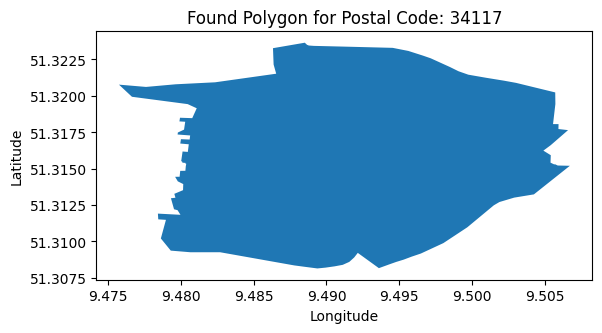

The postal code for the given polygon is: 34117


In [6]:
from shapely.geometry import Polygon, MultiPolygon
from pymongo import MongoClient
import geopandas as gpd
import matplotlib.pyplot as plt

def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    """
    Retrieves GeoJSON data from MongoDB collection.
    """
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_geometry(geometry_type, coordinates):
    """
    Converts coordinates to a Shapely Polygon or MultiPolygon.
    """
    if geometry_type == 'Polygon':
        # Create a Polygon
        return Polygon(coordinates[0])
    elif geometry_type == 'MultiPolygon':
        # Create a MultiPolygon
        return MultiPolygon([Polygon(shell) for shell in coordinates])
    else:
        return None  # Return None for unsupported geometry types

def find_postal_code_for_polygon(target_polygon, postal_code_polygons):
    """
    Finds the postal code for a given polygon among a collection of postal code polygons.
    """
    for postal_code, polygon in postal_code_polygons.items():
        if polygon.intersects(target_polygon):
            return postal_code
    return None

if __name__ == "__main__":
    # MongoDB configuration
    database_name = "ZIP_Poly_Ger_DB_c"
    collection_name = "ZIP_Poly_Ger_Collection_c"

    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Retrieve GeoJSON data from MongoDB
    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    # Load GeoJSON data from MongoDB for comparison
    postal_code_polygons_mongo = {}
    for document in geojson_data_from_mongo['features']:
        postal_code = document.get('postal_code')
        geometry_type = document.get('geometry', {}).get('type')
        coordinates = document.get('geometry', {}).get('coordinates')

        if postal_code and geometry_type and coordinates:
            geometry = coordinates_to_geometry(geometry_type, coordinates)
            if geometry:
                postal_code_polygons_mongo[postal_code] = geometry

    # Example polygon provided
    example_polygon = Polygon([
        (9.4757436, 51.3207645),
        (9.4776032, 51.3206073),
        # ... (add the remaining coordinates)
        (9.4757436, 51.3207645)
    ])

    # Find the postal code for the example polygon
    found_postal_code = find_postal_code_for_polygon(example_polygon, postal_code_polygons_mongo)

    # Plot the found polygon with postal code
    if found_postal_code:
        found_polygon = postal_code_polygons_mongo[found_postal_code]
        gdf_found = gpd.GeoDataFrame(geometry=[found_polygon])
        gdf_found.plot()
        plt.title(f"Found Polygon for Postal Code: {found_postal_code}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
    else:
        print("No postal code found for the given polygon.")

    # Convert example and found polygons to GeoJSON for accessibility
    found_geojson = gdf_found.to_json() if found_postal_code else None

    # Output the result
    if found_postal_code:
        print(f"The postal code for the given polygon is: {found_postal_code}")

    # Close MongoDB connection when done
    mongo_client.close()
